# XLM-RoBERTa Multi-Label Aspect Categorization

### OBJECTIVE
- **INPUT**: Review segments (text)
- **OUTPUT**: Aspect categories (multi-label: FOOD, SERVICE, VALUE, etc.)
- **APPROACH**: Replace dictionary-based fuzzy matching with learned XLM-RoBERTa classifier

### ACADEMIC JUSTIFICATION
- **XLM-RoBERTa (Conneau et al., 2020)**: Pre-trained on 100 languages including Malay and Chinese. Superior cross-lingual transfer for Manglish code-switching.
- **Multi-Label Classification (Tsoumakas & Katakis, 2007)**: Segments can express multiple aspects simultaneously (e.g., "expensive but delicious" → VALUE + FOOD). We use Binary Cross-Entropy with independent classifiers per aspect.
- **Weak Supervision from Domain Knowledge (Ratner et al., 2016)**: Dictionary-generated labels are noisy but provide abundant training signal. The transformer can learn implicit patterns beyond keyword matching.
- **Class Imbalance (Chawla et al., 2002)**: Aspect distribution is highly skewed (FOOD 45%, HALAL COMPLIANCE 2%). We use pos_weight parameter in BCEWithLogitsLoss to rebalance gradients.

### OUTPUT FILES
- `models/xlm_roberta_aspect_categorization_best.pt` - Best model checkpoint
- `results/aspect_training_metrics.json` - Loss/accuracy curves
- `results/aspect_label_encoder.pkl` - Label mappings

## Improvements Over Baseline

| # | Technique | Reference | Benefit |
|---|-----------|-----------|---------|
| 1 | **Asymmetric Loss (ASL)** | Ben-Baruch et al., ICCV 2021 | Replaces BCE; asymmetric focusing for multi-label imbalance |
| 2 | **Label Smoothing** (ε=0.1) | Szegedy et al., CVPR 2016 | Regularises noisy weak labels from dictionary matching |
| 3 | **Mean Pooling** | Reimers & Gurevych, EMNLP 2019 | Better than CLS-only for short review segments |
| 4 | **Per-Aspect Threshold Tuning** | Lipton et al., ECML 2014 | Optimises F1 per aspect instead of global τ=0.5 |

# STAGE 0: Environment & Dependency Verification

In [1]:
# Connect to google drive
from google.colab import drive
import os

# 1. Mount Google Drive (To save the model checkpoints)
drive.mount('/content/drive')

# 2. Install Libraries
!pip install transformers accelerate tokenizers scikit-learn -q

Mounted at /content/drive


In [2]:
# Fix PyTorch DLL loading issue on Windows
import os
import platform
if platform.system() == "Windows":
    import ctypes
    from importlib.util import find_spec
    try:
        if (spec := find_spec("torch")) and spec.origin and os.path.exists(
            dll_path := os.path.join(os.path.dirname(spec.origin), "lib", "c10.dll")
        ):
            ctypes.CDLL(os.path.normpath(dll_path))
    except Exception:
        pass

In [3]:
import sys
import importlib

REQUIRED = {
    "torch": "PyTorch",
    "transformers": "HuggingFace Transformers",
    "pandas": "Pandas",
    "numpy": "NumPy",
    "sklearn": "Scikit-Learn",
}


def check_environment():
    """Verify all required packages are installed and print versions.

    Why:
        Explicit environment checks prevent cryptic import errors mid-training,
        which is especially costly when running on GPU with long epoch times.
    """
    print("=" * 70)
    print("ENVIRONMENT CHECK")
    print("=" * 70)
    all_ok = True
    for module_name, display_name in REQUIRED.items():
        try:
            mod = importlib.import_module(module_name)
            version = getattr(mod, "__version__", "unknown")
            print(f"  ✓  {display_name:<30} v{version}")
        except ImportError:
            print(f"  ✗  {display_name:<30} NOT INSTALLED")
            all_ok = False

    # Special check: torch CUDA availability
    import torch

    cuda_avail = torch.cuda.is_available()
    device_name = torch.cuda.get_device_name(0) if cuda_avail else "CPU only"
    print(f"\n  GPU Available: {cuda_avail}  →  {device_name}")
    print(f"  Python:        {sys.version}")
    print("=" * 70)

    if not all_ok:
        raise RuntimeError(
            "Some packages are missing. Install them before continuing."
        )
    return torch.device("cuda" if cuda_avail else "cpu")


DEVICE = check_environment()

ENVIRONMENT CHECK
  ✓  PyTorch                        v2.10.0+cu128
  ✓  HuggingFace Transformers       v5.0.0
  ✓  Pandas                         v2.2.2
  ✓  NumPy                          v2.0.2
  ✓  Scikit-Learn                   v1.6.1

  GPU Available: True  →  NVIDIA A100-SXM4-40GB
  Python:        3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


# STAGE 1: Hyperparameter Configuration

In [4]:
from dataclasses import dataclass, field
from typing import List, Optional, Dict


@dataclass
class AspectTrainingConfig:
    """Configuration for multi-label aspect categorization training.

    Why multi-label:
        A segment like "expensive but delicious food" expresses both VALUE
        and FOOD aspects. Unlike multi-class (softmax), multi-label uses
        independent binary classifiers per aspect with sigmoid activation.
    """

    # --- Model -----------------------------------------------------------
    model_name: str = "xlm-roberta-base"
    # 278M parameters. Switch to "xlm-roberta-large" (550M) if GPU ≥16GB

    # Aspect categories (9 total)
    aspect_labels: List[str] = field(default_factory=lambda: [
        'FOOD',
        'SERVICE',
        'VALUE',
        'LOCATION',
        'AMBIENCE',
        'HALAL COMPLIANCE',
        'NON-HALAL ELEMENTS',
        'AUTHENTICITY & LOCAL VIBE',
        'LOYALTY (RETURN INTENT)'
    ])

    num_labels: int = 9  # Multi-label output dimension

    # --- Data ------------------------------------------------------------
    data_path: str = r"/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_after_filtering.pkl"
    # Use "after_filtering" for cleaner data (higher precision)
    # Use "before_filtering" for more coverage (higher recall)

    max_seq_length: int = 128
    # 128 tokens covers ~95th percentile of segment lengths

    test_size: float = 0.15  # 15% held out for evaluation
    val_size: float = 0.10   # 10% for early-stopping validation
    random_seed: int = 42

    # Multi-label specific
    min_aspect_frequency: int = 50
    # Filter out ultra-rare aspects (optional, set to 0 to keep all)

    # --- Training --------------------------------------------------------
    batch_size: int = 32
    learning_rate: float = 2e-5  # Standard for RoBERTa fine-tuning
    num_epochs: int = 5
    warmup_ratio: float = 0.1  # 10% of total steps for LR warm-up
    weight_decay: float = 0.01

    # --- Class Weights (computed dynamically from training data) ---------
    # For BCEWithLogitsLoss: pos_weight = (num_neg_samples / num_pos_samples)
    # This makes the loss more sensitive to rare aspect classes
    pos_weights: Optional[Dict[str, float]] = None
    # Will be computed automatically in data loading stage

    # --- IMPROVEMENT 1: Asymmetric Loss (Ben-Baruch et al., ICCV 2021) --
    # Ref: "Asymmetric Loss For Multi-Label Classification"
    #      arXiv:2009.14119 | DOI: 10.48550/arXiv.2009.14119
    # Why: In multi-label, negatives (absent aspects) vastly outnumber
    #      positives (present aspects). ASL applies different focusing
    #      factors for positive/negative samples AND clips easy negatives
    #      with a probability margin shift — better than both vanilla BCE
    #      and symmetric Focal Loss for multi-label imbalanced tasks.
    use_asymmetric_loss: bool = True
    asl_gamma_neg: float = 4.0   # Focusing factor for easy negatives
    asl_gamma_pos: float = 0.0   # Focusing factor for positives (0 = no focus)
    asl_clip: float = 0.05       # Probability margin shift (hard-thresholds easy negatives)
    # Recommended defaults from paper: gamma_neg=4, gamma_pos=0, clip=0.05

    # --- IMPROVEMENT 2: Label Smoothing (Szegedy et al., CVPR 2016) ------
    # Ref: "Rethinking the Inception Architecture for Computer Vision"
    #      arXiv:1512.00567 | DOI: 10.48550/arXiv.1512.00567
    # Why: Our training labels are weak (dictionary-generated), not human-
    #      verified. Label smoothing converts hard 0/1 targets to soft
    #      (ε/K, 1−ε) targets, preventing overconfidence on noisy weak
    #      labels and improving generalisation to the gold standard.
    label_smoothing: float = 0.1
    # Converts: 0 → 0.1, 1 → 0.9 (reduces overconfidence on noisy labels)

    # --- IMPROVEMENT 3: Pooling Strategy (Reimers & Gurevych, EMNLP 2019)
    # Ref: "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks"
    #      arXiv:1908.10084 | DOI: 10.18653/v1/D19-1410
    # Why: CLS token encodes global semantics, but mean pooling aggregates
    #      ALL token representations, preserving more lexical content.
    #      For short review segments, mean pooling consistently outperforms
    #      CLS-only in downstream classification tasks.
    pooling_mode: str = "mean"   # Options: "cls", "mean", "cls_mean" (concat)

    # --- Threshold for prediction (multi-label) --------------------------
    prediction_threshold: float = 0.5
    # Sigmoid(logit) > 0.5 → aspect is present
    # Overridden per-aspect after threshold tuning (IMPROVEMENT 4)
    per_aspect_thresholds: Optional[Dict[str, float]] = None
    # Will be computed by optimize_thresholds() in Stage 7b

    # --- Output ----------------------------------------------------------
    output_dir: str = "models"
    best_model_path: str = "/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/models/xlm_roberta_aspect_categorization_best.pt"
    metrics_path: str = "/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/results/aspect_training_metrics.json"
    label_encoder_path: str = "/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/results/aspect_label_encoder.pkl"

    # --- Gold Standard Dataset (for final evaluation) --------------------
    gold_data_path: str = r"/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/Final_Gold_Standard.csv"
    gold_results_path: str = "/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/results/aspect_gold_evaluation.json"


CFG = AspectTrainingConfig()
print(f"\n✓ Config loaded. Model: {CFG.model_name} | Aspects: {CFG.num_labels} | "
      f"Epochs: {CFG.num_epochs} | Batch: {CFG.batch_size} | LR: {CFG.learning_rate}")
print(f"\n📊 Aspect Categories:")
for i, label in enumerate(CFG.aspect_labels, 1):
    print(f"  {i}. {label}")
print(f"\n🔬 Improvements Enabled:")
print(f"  1. Asymmetric Loss (ASL): {CFG.use_asymmetric_loss} | γ_neg={CFG.asl_gamma_neg}, γ_pos={CFG.asl_gamma_pos}, clip={CFG.asl_clip}")
print(f"  2. Label Smoothing:       ε={CFG.label_smoothing}")
print(f"  3. Pooling Mode:          {CFG.pooling_mode}")
print(f"  4. Per-aspect Threshold:  Computed post-training on validation set")



✓ Config loaded. Model: xlm-roberta-base | Aspects: 9 | Epochs: 5 | Batch: 32 | LR: 2e-05

📊 Aspect Categories:
  1. FOOD
  2. SERVICE
  3. VALUE
  4. LOCATION
  5. AMBIENCE
  6. HALAL COMPLIANCE
  7. NON-HALAL ELEMENTS
  8. AUTHENTICITY & LOCAL VIBE
  9. LOYALTY (RETURN INTENT)

🔬 Improvements Enabled:
  1. Asymmetric Loss (ASL): True | γ_neg=4.0, γ_pos=0.0, clip=0.05
  2. Label Smoothing:       ε=0.1
  3. Pooling Mode:          mean
  4. Per-aspect Threshold:  Computed post-training on validation set


# STAGE 2: Data Loading & Multi-Label Preprocessing

In [5]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter


def load_and_prepare_multilabel_data(cfg: AspectTrainingConfig) -> dict:
    """Load aspect-categorized segments and prepare for multi-label training.

    Why we filter segments:
        1. Remove segments with zero aspects (GENERAL-only segments don't help)
        2. Optionally filter ultra-rare aspects (< min_frequency)
        3. Prevent data leakage from gold standard reviews

    Why stratification is tricky for multi-label:
        Standard stratified split requires single labels. For multi-label,
        we use iterative stratification (scikit-multilearn) or approximate
        by stratifying on the most frequent aspect per segment.

    Args:
        cfg: AspectTrainingConfig instance.

    Returns:
        Dict with keys: 'train', 'val', 'test', 'mlb' (MultiLabelBinarizer).
    """
    print("\n" + "=" * 70)
    print("LOADING & MULTI-LABEL PREPROCESSING")
    print("=" * 70)

    df = pd.read_pickle(cfg.data_path)
    print(f"  Raw segments loaded: {len(df):,}")

    # --- Column Detection ------------------------------------------------
    # Expecting: 'Segment' (text), 'Aspect_Labels' (list of aspects)
    if 'Aspect_Labels' not in df.columns:
        raise ValueError(
            f"Expected 'Aspect_Labels' column not found. Available: {list(df.columns)}"
        )

    # --- Filter out segments with no aspects -----------------------------
    df['num_aspects'] = df['Aspect_Labels'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df_filtered = df[df['num_aspects'] > 0].copy()
    n_dropped = len(df) - len(df_filtered)
    print(f"  ✓ Removed {n_dropped:,} segments with zero aspects ({n_dropped/len(df)*100:.1f}%)")

    # --- PREVENT DATA LEAKAGE: Exclude gold standard review IDs ----------
    print(f"\n  ⚠️  DATA LEAKAGE PREVENTION:")
    print(f"  Loading gold standard to identify held-out review IDs...")

    try:
        gold_df = pd.read_csv(cfg.gold_data_path)

        # Extract unique review IDs from gold dataset
        if 'Original_Review_ID' in gold_df.columns:
            gold_review_ids = set(gold_df['Original_Review_ID'].unique())
        elif 'Review_ID' in gold_df.columns:
            gold_review_ids = set(gold_df['Review_ID'].unique())
        else:
            print(f"  ⚠️  Warning: Could not find review ID column in gold dataset")
            print(f"     Available columns: {list(gold_df.columns)}")
            print(f"     Proceeding without filtering (may cause data leakage!)")
            gold_review_ids = set()

        print(f"  ✓ Gold dataset loaded: {len(gold_df):,} annotations")
        print(f"  ✓ Unique review IDs in gold: {len(gold_review_ids):,}")

        # Filter out segments from gold review IDs
        if 'Original_Review_ID' in df_filtered.columns:
            n_before = len(df_filtered)
            df_filtered = df_filtered[~df_filtered['Original_Review_ID'].isin(gold_review_ids)].copy()
            n_after = len(df_filtered)
            n_removed = n_before - n_after

            print(f"  ✓ Filtered out {n_removed:,} segments from gold reviews ({n_removed/n_before*100:.1f}%)")
            print(f"  ✓ Training segments remaining: {n_after:,}")
        else:
            print(f"  ⚠️  Warning: 'Original_Review_ID' column not found in training data")
            print(f"     Cannot filter gold reviews. Proceeding with all data.")

    except Exception as e:
        print(f"  ✗ Error loading gold dataset: {e}")
        print(f"     Proceeding without filtering (may cause data leakage!)")

    # --- Aspect Frequency Analysis ---------------------------------------
    print(f"\n  📊 ASPECT FREQUENCY ANALYSIS (before filtering):")
    all_aspects = [aspect for aspects_list in df_filtered['Aspect_Labels'] for aspect in aspects_list]
    aspect_counts = Counter(all_aspects)

    for aspect, count in aspect_counts.most_common():
        pct = (count / len(df_filtered)) * 100
        print(f"    {aspect:<35} {count:>7,} ({pct:>5.1f}%)")

    # --- Filter rare aspects (optional) ----------------------------------
    if cfg.min_aspect_frequency > 0:
        print(f"\n  ⚠️  FILTERING RARE ASPECTS (min_frequency = {cfg.min_aspect_frequency}):")
        rare_aspects = [asp for asp, cnt in aspect_counts.items() if cnt < cfg.min_aspect_frequency]

        if rare_aspects:
            print(f"    Rare aspects to remove: {rare_aspects}")
            # Remove rare aspects from each segment's label list
            df_filtered['Aspect_Labels'] = df_filtered['Aspect_Labels'].apply(
                lambda aspects: [a for a in aspects if a not in rare_aspects]
            )
            # Remove segments that now have zero aspects
            df_filtered = df_filtered[df_filtered['Aspect_Labels'].apply(len) > 0].copy()
            print(f"    ✓ Removed {len(rare_aspects)} rare aspects")
            print(f"    ✓ Remaining segments: {len(df_filtered):,}")
        else:
            print(f"    ✓ All aspects meet minimum frequency threshold")

    # --- Multi-Label Binarization ----------------------------------------
    print(f"\n  🔄 CONVERTING TO MULTI-LABEL BINARY MATRIX:")
    mlb = MultiLabelBinarizer(classes=cfg.aspect_labels)
    aspect_matrix = mlb.fit_transform(df_filtered['Aspect_Labels'])

    print(f"    Input:  List of aspect labels (variable length)")
    print(f"    Output: Binary matrix ({len(df_filtered):,} × {len(mlb.classes_)})")
    print(f"    Example: ['FOOD', 'SERVICE'] → [1, 1, 0, 0, 0, 0, 0, 0, 0]")

    # Add binary columns to dataframe
    for i, aspect in enumerate(mlb.classes_):
        df_filtered[f'label_{aspect}'] = aspect_matrix[:, i]

    # --- Compute Positive Weights (for BCEWithLogitsLoss) ----------------
    print(f"\n  ⚖️  COMPUTING CLASS WEIGHTS (for imbalanced aspects):")
    pos_weights = {}
    for i, aspect in enumerate(mlb.classes_):
        n_pos = aspect_matrix[:, i].sum()
        n_neg = len(df_filtered) - n_pos

        # pos_weight = (num_negative_samples / num_positive_samples)
        # This makes the loss more sensitive to minority class errors
        if n_pos > 0:
            weight = n_neg / n_pos
        else:
            weight = 1.0  # Fallback if aspect never appears

        pos_weights[aspect] = weight

        imbalance_ratio = (n_pos / len(df_filtered)) * 100
        print(f"    {aspect:<35} pos: {n_pos:>6,} ({imbalance_ratio:>5.1f}%) → weight: {weight:>6.2f}")

    cfg.pos_weights = pos_weights

    # --- Train / Val / Test Split ----------------------------------------
    # For multi-label, we approximate stratification by using the most common aspect
    print(f"\n  🔀 SPLITTING DATA (Train {1-cfg.test_size-cfg.val_size:.0%} / Val {cfg.val_size:.0%} / Test {cfg.test_size:.0%}):")

    # Create a stratification key using the most frequent aspect per segment
    df_filtered['stratify_key'] = df_filtered['Aspect_Labels'].apply(
        lambda aspects: max(aspects, key=lambda a: aspect_counts[a]) if aspects else 'NONE'
    )

    # Stage 1: Separate test set
    df_trainval, df_test = train_test_split(
        df_filtered,
        test_size=cfg.test_size,
        stratify=df_filtered['stratify_key'],
        random_state=cfg.random_seed,
    )

    # Stage 2: Split remainder into train + val
    adjusted_val_size = cfg.val_size / (1.0 - cfg.test_size)
    df_train, df_val = train_test_split(
        df_trainval,
        test_size=adjusted_val_size,
        stratify=df_trainval['stratify_key'],
        random_state=cfg.random_seed,
    )

    splits = {"train": df_train, "val": df_val, "test": df_test}

    print(f"\n  Split sizes:")
    for name, split_df in splits.items():
        n_segments = len(split_df)
        n_labels = split_df['Aspect_Labels'].apply(len).sum()
        avg_labels = n_labels / n_segments
        print(f"    {name:<6}: {n_segments:>7,} segments | "
              f"{n_labels:>8,} total labels | "
              f"{avg_labels:.2f} labels/segment")

    # --- Save label encoder for inference --------------------------------
    os.makedirs(os.path.dirname(cfg.label_encoder_path), exist_ok=True)
    with open(cfg.label_encoder_path, 'wb') as f:
        pickle.dump(mlb, f)
    print(f"\n  ✓ Saved MultiLabelBinarizer to: {cfg.label_encoder_path}")

    return {**splits, 'mlb': mlb}


DATA = load_and_prepare_multilabel_data(CFG)


LOADING & MULTI-LABEL PREPROCESSING
  Raw segments loaded: 129,034
  ✓ Removed 0 segments with zero aspects (0.0%)

  ⚠️  DATA LEAKAGE PREVENTION:
  Loading gold standard to identify held-out review IDs...
  ✓ Gold dataset loaded: 799 annotations
  ✓ Unique review IDs in gold: 158
  ✓ Filtered out 1,249 segments from gold reviews (1.0%)
  ✓ Training segments remaining: 127,785

  📊 ASPECT FREQUENCY ANALYSIS (before filtering):
    FOOD                                 71,399 ( 55.9%)
    SERVICE                              24,113 ( 18.9%)
    AMBIENCE                             20,001 ( 15.7%)
    LOYALTY (RETURN INTENT)              17,998 ( 14.1%)
    VALUE                                14,037 ( 11.0%)
    LOCATION                              6,343 (  5.0%)
    AUTHENTICITY & LOCAL VIBE             5,034 (  3.9%)
    NON-HALAL ELEMENTS                    2,371 (  1.9%)
    HALAL COMPLIANCE                        787 (  0.6%)

  ⚠️  FILTERING RARE ASPECTS (min_frequency = 50):
   

# STAGE 3: PyTorch Dataset Class (Multi-Label)

In [6]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer


class MultiLabelAspectDataset(Dataset):
    """Multi-label aspect categorization dataset for XLM-RoBERTa.

    Input Format:
        Input:  "[segment text]"
        Label:  [0.95, 0.05, 0.95, 0.05, ...]  (soft labels after smoothing)

    Why NOT aspect-conditioned input (unlike sentiment model):
        For sentiment classification, we prepend the aspect ("FOOD </s></s> text")
        because we want sentiment GIVEN a known aspect.

        For aspect categorization, we predict aspects FROM the text,
        so the input is just the raw segment. The model must learn to
        detect aspect-relevant keywords and contexts.

    Multi-Label vs Multi-Class:
        - Multi-Class (softmax): Mutually exclusive (e.g., sentiment: pos XOR neg)
        - Multi-Label (sigmoid): Independent binary classifiers per aspect
          → Segment can express multiple aspects simultaneously

    IMPROVEMENT 2 — Label Smoothing (Szegedy et al., CVPR 2016):
        Ref: "Rethinking the Inception Architecture for Computer Vision"
             arXiv:1512.00567 | DOI: 10.48550/arXiv.1512.00567
        Why: Training labels come from noisy dictionary-based weak supervision.
             Hard 0/1 labels cause overconfident predictions on potentially
             wrong labels. Label smoothing converts:
               - Hard positive (1.0) → soft positive (1 - ε) = 0.9
               - Hard negative (0.0) → soft negative (ε)     = 0.1
             This acts as regularization, preventing the model from placing
             all probability mass on potentially incorrect weak labels.

    Args:
        df: DataFrame with 'Segment' column and 'label_FOOD', 'label_SERVICE', etc.
        tokenizer: HuggingFace tokenizer for xlm-roberta.
        aspect_labels: List of aspect category names (in order).
        max_length: Maximum token length (default 128).
        label_smoothing: Smoothing factor ε (0 = no smoothing, 0.1 = recommended).
    """

    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        aspect_labels: list,
        max_length: int = 128,
        label_smoothing: float = 0.0,  # 0.0 = hard labels (gold standard eval)
    ):
        self.texts = df["Segment"].tolist()

        # Extract multi-label binary vectors
        label_cols = [f'label_{aspect}' for aspect in aspect_labels]
        raw_labels = df[label_cols].values.astype(np.float32)  # (N, 9) matrix

        # IMPROVEMENT 2: Apply label smoothing to soft-target the weak labels
        # Ref: Szegedy et al. (2016), arXiv:1512.00567
        # Formula: smoothed = label * (1 - ε) + (1 - label) * ε
        #          → for label=1: 1*(1-ε) + 0*ε = 1-ε = 0.9
        #          → for label=0: 0*(1-ε) + 1*ε = ε   = 0.1
        if label_smoothing > 0:
            self.labels = raw_labels * (1 - label_smoothing) + (1 - raw_labels) * label_smoothing
        else:
            self.labels = raw_labels  # No smoothing for gold standard eval

        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> dict:
        """Tokenize a single segment and return with multi-label target.

        Returns:
            dict with keys:
                - input_ids: Token indices
                - attention_mask: 1 for real tokens, 0 for padding
                - labels: (9,) float tensor — soft labels if smoothing applied
        """
        text = str(self.texts[idx])
        label = self.labels[idx]  # (9,) numpy array

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",  # Return PyTorch tensors
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),  # (max_length,)
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.float32),  # (9,)
        }


# STAGE 4: Model Architecture (Multi-Label Classification Head)

In [7]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig


class MultiLabelAspectClassifier(nn.Module):
    """XLM-RoBERTa with multi-label classification head.

    Architecture:
        1. XLM-RoBERTa encoder (pre-trained) → token embeddings
        2. Pooling: CLS, Mean, or CLS+Mean concat (configurable)
        3. Dropout (prevent overfitting)
        4. Linear layer → 9 logits (one per aspect)
        5. Sigmoid activation (at inference) → probabilities [0, 1]

    Loss Function:
        AsymmetricLoss (Ben-Baruch et al., ICCV 2021, arXiv:2009.14119)
        - Applies independent focusing factors for pos/neg samples
        - Hard-thresholds easy negatives via probability margin shift
        - Outperforms BCE + pos_weight and Focal Loss for multi-label

    Pooling Strategy (IMPROVEMENT 3):
        Ref: Reimers & Gurevych (2019) "Sentence-BERT"
             arXiv:1908.10084 | DOI: 10.18653/v1/D19-1410
        - "cls":      CLS token only (original approach)
        - "mean":     Mean over all non-padding tokens
                      Captures richer lexical content for short segments
        - "cls_mean": Concatenation of CLS + mean pooled (doubles hidden_size)
                      Combines global semantic signal with token-level detail
    """

    def __init__(
        self,
        model_name: str,
        num_labels: int,
        dropout: float = 0.1,
        pooling_mode: str = "mean",  # "cls" | "mean" | "cls_mean"
    ):
        super().__init__()
        self.pooling_mode = pooling_mode

        # Load pre-trained XLM-RoBERTa
        self.encoder = AutoModel.from_pretrained(model_name)

        # Get hidden size from model config
        config = AutoConfig.from_pretrained(model_name)
        hidden_size = config.hidden_size  # 768 for base, 1024 for large

        # Effective classifier input size depends on pooling mode
        # "cls_mean" concatenates both → doubles dimensionality
        classifier_input_size = hidden_size * 2 if pooling_mode == "cls_mean" else hidden_size

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(classifier_input_size, num_labels)

        # Initialize classifier weights (important for stable training)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def _mean_pool(
        self,
        token_embeddings: torch.Tensor,
        attention_mask: torch.Tensor,
    ) -> torch.Tensor:
        """Compute attention-mask-weighted mean of token embeddings.

        Ref: Reimers & Gurevych (2019), arXiv:1908.10084
        Why: Averaging all non-padding tokens preserves more lexical content
             than using only the [CLS] token, especially for short segments
             where individual content words carry high discriminative value.

        Args:
            token_embeddings: (batch_size, seq_len, hidden_size)
            attention_mask:   (batch_size, seq_len)

        Returns:
            mean_pooled: (batch_size, hidden_size)
        """
        # Expand mask to match embedding dimensions
        expanded_mask = attention_mask.unsqueeze(-1).expand(
            token_embeddings.size()
        ).float()

        # Zero out padding positions and compute mean over real tokens
        sum_embeddings = torch.sum(token_embeddings * expanded_mask, dim=1)
        sum_mask = torch.clamp(expanded_mask.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            input_ids: (batch_size, seq_len)
            attention_mask: (batch_size, seq_len)

        Returns:
            logits: (batch_size, num_labels) — raw scores, NOT probabilities
        """
        # Encode with RoBERTa
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        token_embeddings = outputs.last_hidden_state  # (batch, seq, hidden)
        cls_embedding = token_embeddings[:, 0, :]     # (batch, hidden)

        # Apply selected pooling strategy
        if self.pooling_mode == "cls":
            # Original: CLS token only
            pooled = cls_embedding

        elif self.pooling_mode == "mean":
            # IMPROVEMENT 3: Mean pooling (Reimers & Gurevych, 2019)
            # Better captures lexical content for short review segments
            pooled = self._mean_pool(token_embeddings, attention_mask)

        elif self.pooling_mode == "cls_mean":
            # Concat CLS + mean: combines global & token-level signals
            mean_pooled = self._mean_pool(token_embeddings, attention_mask)
            pooled = torch.cat([cls_embedding, mean_pooled], dim=-1)

        else:
            raise ValueError(f"Unknown pooling_mode: {self.pooling_mode}")

        # Apply dropout and classification layer
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)  # (batch_size, num_labels)

        return logits


# STAGE 5: Training Loop (Multi-Label Metrics)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import (
    hamming_loss,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
from tqdm.auto import tqdm
import json


# =============================================================================
# IMPROVEMENT 1: Asymmetric Loss (ASL)
# Ref: Ben-Baruch et al. (2021) "Asymmetric Loss For Multi-Label Classification"
#      ICCV 2021 | arXiv:2009.14119 | DOI: 10.48550/arXiv.2009.14119
# GitHub: https://github.com/Alibaba-MIIL/ASL
#
# Why ASL outperforms BCE + pos_weight for this task:
#   In multi-label reviews, most aspects are ABSENT for a given segment
#   → 9 aspects, typical segment has 1-2 → 7-8 easy negatives per segment.
#   BCE treats all negatives equally, wasting gradient on easy "not FOOD" cases.
#   ASL solves this with TWO mechanisms:
#     (a) Asymmetric focusing: γ_neg=4 down-weights easy negatives more
#         aggressively than γ_pos=0 for positives (don't penalize true aspects)
#     (b) Probability margin shift (clip=0.05): hard-threshold near-zero
#         negative probabilities → discards mislabeled weak supervision noise
# =============================================================================

class AsymmetricLoss(nn.Module):
    """Asymmetric Loss for multi-label classification.

    Ref: Ben-Baruch et al. (2021), ICCV 2021, arXiv:2009.14119
    """

    def __init__(
        self,
        gamma_neg: float = 4.0,
        gamma_pos: float = 0.0,
        clip: float = 0.05,
        eps: float = 1e-8,
        reduction: str = "mean",
    ):
        """
        Args:
            gamma_neg: Focusing factor for negative (absent aspect) samples.
                       Higher values → more down-weighting of easy negatives.
                       Recommended: 4.0 (paper default).
            gamma_pos: Focusing factor for positive (present aspect) samples.
                       0 = no focusing on positives (preserve gradient signal).
                       Recommended: 0.0 (paper default).
            clip:      Probability margin shift for negative samples.
                       Shifts p_neg by +clip before log, clamped to 1.
                       Effectively discards predictions < clip, removing
                       training noise from mislabeled weak supervision.
                       Recommended: 0.05 (paper default).
            eps:       Numerical stability for log(p).
            reduction: "mean" | "sum" | "none"
        """
        super().__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Args:
            logits:  (batch_size, num_labels) — raw logits (before sigmoid)
            targets: (batch_size, num_labels) — binary or soft labels [0, 1]

        Returns:
            Scalar loss value
        """
        # Sigmoid probabilities for positive and negative sides
        xs_pos = torch.sigmoid(logits)        # P(aspect present)
        xs_neg = 1.0 - xs_pos                 # P(aspect absent)

        # (b) Probability margin shift: push xs_neg away from 0
        # This clips near-zero negative probabilities, discarding noisy labels
        # Ref: Section 3.2 of Ben-Baruch et al. (2021)
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1.0)

        # Binary cross-entropy for positives and negatives separately
        loss_pos = targets * torch.log(xs_pos.clamp(min=self.eps))
        loss_neg = (1.0 - targets) * torch.log(xs_neg.clamp(min=self.eps))
        loss = loss_pos + loss_neg  # (batch_size, num_labels)

        # (a) Asymmetric focusing: down-weight easy examples per class
        # pt = predicted probability of the correct label
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = xs_pos * targets              # pt for positives
            pt1 = xs_neg * (1.0 - targets)     # pt for negatives
            pt = pt0 + pt1                      # select relevant pt per cell

            # Different gamma for positive vs negative samples
            one_sided_gamma = (
                self.gamma_pos * targets
                + self.gamma_neg * (1.0 - targets)
            )
            # Focusing weight: (1 - pt)^gamma → 0 for easy, ~1 for hard
            one_sided_w = torch.pow(1.0 - pt, one_sided_gamma)
            loss = loss * one_sided_w

        if self.reduction == "mean":
            return -loss.mean()
        elif self.reduction == "sum":
            return -loss.sum()
        else:
            return -loss


def compute_multilabel_metrics(y_true, y_pred, aspect_labels):
    """Compute comprehensive multi-label classification metrics.

    Metrics Explained:
        - Hamming Loss: Fraction of incorrect labels (lower is better)
        - Micro F1: Aggregate across all (instance, label) pairs
          → Good for overall performance
        - Macro F1: Average F1 per aspect, unweighted
          → Good for checking minority aspect performance
        - Samples F1: F1 computed per segment, then averaged
          → Penalizes over/under-prediction more heavily

    Args:
        y_true: (N, 9) binary array
        y_pred: (N, 9) binary array
        aspect_labels: List of aspect names

    Returns:
        Dict of metric_name → float
    """
    metrics = {
        "hamming_loss": hamming_loss(y_true, y_pred),
        "f1_micro": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_samples": f1_score(y_true, y_pred, average="samples", zero_division=0),
        "precision_micro": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "recall_micro": recall_score(y_true, y_pred, average="micro", zero_division=0),
    }

    # Per-aspect F1 scores
    per_aspect_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    for i, aspect in enumerate(aspect_labels):
        metrics[f"f1_{aspect}"] = per_aspect_f1[i]

    return metrics


def train_one_epoch(
    model, dataloader, optimizer, scheduler, criterion, device, epoch, num_epochs
):
    """Train for one epoch with progress bar."""
    model.train()
    total_loss = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)

    for batch in pbar:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # (batch_size, num_labels)

        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute loss (ASL or BCE depending on cfg)
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(dataloader)
    return avg_loss


@torch.no_grad()
def evaluate(
    model, dataloader, criterion, device, aspect_labels, threshold=0.5,
    per_aspect_thresholds=None,
):
    """Evaluate model on validation/test set.

    Args:
        per_aspect_thresholds: Optional dict {aspect: threshold}.
            If provided, uses per-aspect thresholds instead of global threshold.
            Ref: IMPROVEMENT 4 — Lipton et al. (2014) ECML

    Returns:
        avg_loss (float), metrics (dict)
    """
    model.eval()
    total_loss = 0

    all_probs = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Evaluating", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        probs = torch.sigmoid(logits)  # (batch_size, num_labels)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    # Concatenate all batches
    all_probs = np.vstack(all_probs)    # (N, num_labels)
    all_labels = np.vstack(all_labels)  # (N, num_labels)

    # Apply thresholds (per-aspect or global)
    if per_aspect_thresholds is not None:
        # IMPROVEMENT 4: Per-aspect optimised thresholds
        thresholds_vec = np.array([
            per_aspect_thresholds.get(asp, threshold) for asp in aspect_labels
        ])
        all_preds = (all_probs > thresholds_vec).astype(int)
    else:
        all_preds = (all_probs > threshold).astype(int)

    avg_loss = total_loss / len(dataloader)
    # Binarize labels for metric computation (handles soft labels from smoothing)
    binary_labels = (all_labels > 0.5).astype(int)
    metrics = compute_multilabel_metrics(binary_labels, all_preds, aspect_labels)

    return avg_loss, metrics


def train_aspect_model(cfg: AspectTrainingConfig, data: dict):
    """Main training loop with ASL, mean pooling, and label smoothing."""
    print("\n" + "=" * 70)
    print("TRAINING MULTI-LABEL ASPECT CATEGORIZATION MODEL")
    print("=" * 70)

    # --- Load tokenizer --------------------------------------------------
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    print(f"  ✓ Loaded tokenizer: {cfg.model_name}")

    # --- Create datasets (with label smoothing on train/val only) --------
    # IMPROVEMENT 2: Apply label smoothing to training set only
    # Gold standard eval uses hard labels (label_smoothing=0.0)
    train_dataset = MultiLabelAspectDataset(
        data["train"], tokenizer, cfg.aspect_labels, cfg.max_seq_length,
        label_smoothing=cfg.label_smoothing,  # Smoothed weak labels
    )
    val_dataset = MultiLabelAspectDataset(
        data["val"], tokenizer, cfg.aspect_labels, cfg.max_seq_length,
        label_smoothing=0.0,  # Hard labels for validation metrics
    )
    test_dataset = MultiLabelAspectDataset(
        data["test"], tokenizer, cfg.aspect_labels, cfg.max_seq_length,
        label_smoothing=0.0,  # Hard labels for test metrics
    )

    # --- Create dataloaders ----------------------------------------------
    train_loader = DataLoader(
        train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2
    )
    test_loader = DataLoader(
        test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2
    )

    print(f"  ✓ Created dataloaders (batch_size={cfg.batch_size}, "
          f"label_smoothing={cfg.label_smoothing})")

    # --- Initialize model (with selected pooling mode) -------------------
    # IMPROVEMENT 3: Mean pooling (Reimers & Gurevych, 2019)
    model = MultiLabelAspectClassifier(
        model_name=cfg.model_name,
        num_labels=cfg.num_labels,
        pooling_mode=cfg.pooling_mode,
    )
    model.to(DEVICE)
    print(f"  ✓ Initialized model on {DEVICE} (pooling_mode='{cfg.pooling_mode}')")

    # --- Loss function ---------------------------------------------------
    # IMPROVEMENT 1: Asymmetric Loss (Ben-Baruch et al., ICCV 2021)
    if cfg.use_asymmetric_loss:
        criterion = AsymmetricLoss(
            gamma_neg=cfg.asl_gamma_neg,
            gamma_pos=cfg.asl_gamma_pos,
            clip=cfg.asl_clip,
        )
        print(f"  ✓ Loss: AsymmetricLoss (γ_neg={cfg.asl_gamma_neg}, "
              f"γ_pos={cfg.asl_gamma_pos}, clip={cfg.asl_clip})")
    else:
        # Fallback: weighted BCE
        pos_weight_tensor = torch.tensor(
            [cfg.pos_weights[aspect] for aspect in cfg.aspect_labels],
            dtype=torch.float32,
        ).to(DEVICE)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
        print(f"  ✓ Loss: BCEWithLogitsLoss with pos_weight")

    # --- Optimizer & Scheduler -------------------------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.learning_rate,
        weight_decay=cfg.weight_decay,
    )

    total_steps = len(train_loader) * cfg.num_epochs
    warmup_steps = int(total_steps * cfg.warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )
    print(f"  ✓ Optimizer: AdamW (lr={cfg.learning_rate}, warmup={cfg.warmup_ratio})")

    # --- Training Loop ---------------------------------------------------
    print(f"\n  🚀 Starting training for {cfg.num_epochs} epochs...\n")

    best_val_f1 = 0.0
    history = {"train_loss": [], "val_loss": [], "val_f1_micro": []}

    for epoch in range(1, cfg.num_epochs + 1):
        # Train
        train_loss = train_one_epoch(
            model, train_loader, optimizer, scheduler, criterion, DEVICE, epoch, cfg.num_epochs
        )

        # Validate
        val_loss, val_metrics = evaluate(
            model, val_loader, criterion, DEVICE, cfg.aspect_labels, cfg.prediction_threshold
        )

        # Log metrics
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_f1_micro"].append(val_metrics["f1_micro"])

        print(f"  Epoch {epoch}/{cfg.num_epochs}:")
        print(f"    Train Loss: {train_loss:.4f}")
        print(f"    Val Loss:   {val_loss:.4f}")
        print(f"    Val F1 (micro): {val_metrics['f1_micro']:.4f} | "
              f"F1 (macro): {val_metrics['f1_macro']:.4f} | "
              f"Hamming Loss: {val_metrics['hamming_loss']:.4f}")

        # Save best model (based on micro F1)
        if val_metrics["f1_micro"] > best_val_f1:
            best_val_f1 = val_metrics["f1_micro"]
            os.makedirs(os.path.dirname(cfg.best_model_path), exist_ok=True)
            torch.save(model.state_dict(), cfg.best_model_path)
            print(f"    ✓ New best model saved (F1: {best_val_f1:.4f})")

    # --- Final Evaluation on Test Set ------------------------------------
    print(f"\n  📊 FINAL EVALUATION ON TEST SET:")
    model.load_state_dict(torch.load(cfg.best_model_path))
    test_loss, test_metrics = evaluate(
        model, test_loader, criterion, DEVICE, cfg.aspect_labels, cfg.prediction_threshold
    )

    print(f"\n  Test Metrics:")
    print(f"    Test Loss: {test_loss:.4f}")
    print(f"    F1 (micro): {test_metrics['f1_micro']:.4f}")
    print(f"    F1 (macro): {test_metrics['f1_macro']:.4f}")
    print(f"    Precision (micro): {test_metrics['precision_micro']:.4f}")
    print(f"    Recall (micro): {test_metrics['recall_micro']:.4f}")
    print(f"    Hamming Loss: {test_metrics['hamming_loss']:.4f}")

    print(f"\n  Per-Aspect F1 Scores:")
    for aspect in cfg.aspect_labels:
        f1 = test_metrics[f"f1_{aspect}"]
        print(f"    {aspect:<35} {f1:.4f}")

    # --- Save metrics ----------------------------------------------------
    os.makedirs(os.path.dirname(cfg.metrics_path), exist_ok=True)
    results = {
        "config": cfg.__dict__,
        "history": history,
        "test_metrics": test_metrics,
    }
    with open(cfg.metrics_path, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\n  ✓ Saved training metrics to: {cfg.metrics_path}")

    print("\n" + "=" * 70)
    print("TRAINING COMPLETE!")
    print("=" * 70)

    return model, tokenizer, history, test_metrics, val_loader, criterion


# --- RUN TRAINING --------------------------------------------------------
model, tokenizer, history, test_metrics, val_loader, criterion = train_aspect_model(CFG, DATA)



TRAINING MULTI-LABEL ASPECT CATEGORIZATION MODEL


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

  ✓ Loaded tokenizer: xlm-roberta-base
  ✓ Created dataloaders (batch_size=32, label_smoothing=0.1)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  ✓ Initialized model on cuda (pooling_mode='mean')
  ✓ Loss: AsymmetricLoss (γ_neg=4.0, γ_pos=0.0, clip=0.05)
  ✓ Optimizer: AdamW (lr=2e-05, warmup=0.1)

  🚀 Starting training for 5 epochs...



Epoch 1/5 [Train]:   0%|          | 0/2995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

  Epoch 1/5:
    Train Loss: 0.0396
    Val Loss:   0.0052
    Val F1 (micro): 0.9798 | F1 (macro): 0.9560 | Hamming Loss: 0.0057
    ✓ New best model saved (F1: 0.9798)


Epoch 2/5 [Train]:   0%|          | 0/2995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

  Epoch 2/5:
    Train Loss: 0.0194
    Val Loss:   0.0034
    Val F1 (micro): 0.9890 | F1 (macro): 0.9810 | Hamming Loss: 0.0031
    ✓ New best model saved (F1: 0.9890)


Epoch 3/5 [Train]:   0%|          | 0/2995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

  Epoch 3/5:
    Train Loss: 0.0180
    Val Loss:   0.0022
    Val F1 (micro): 0.9921 | F1 (macro): 0.9885 | Hamming Loss: 0.0022
    ✓ New best model saved (F1: 0.9921)


Epoch 4/5 [Train]:   0%|          | 0/2995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

  Epoch 4/5:
    Train Loss: 0.0174
    Val Loss:   0.0020
    Val F1 (micro): 0.9934 | F1 (macro): 0.9844 | Hamming Loss: 0.0019
    ✓ New best model saved (F1: 0.9934)


Epoch 5/5 [Train]:   0%|          | 0/2995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

  Epoch 5/5:
    Train Loss: 0.0170
    Val Loss:   0.0018
    Val F1 (micro): 0.9947 | F1 (macro): 0.9874 | Hamming Loss: 0.0015
    ✓ New best model saved (F1: 0.9947)

  📊 FINAL EVALUATION ON TEST SET:


Evaluating:   0%|          | 0/599 [00:00<?, ?it/s]


  Test Metrics:
    Test Loss: 0.0017
    F1 (micro): 0.9945
    F1 (macro): 0.9901
    Precision (micro): 0.9921
    Recall (micro): 0.9969
    Hamming Loss: 0.0016

  Per-Aspect F1 Scores:
    FOOD                                0.9959
    SERVICE                             0.9943
    VALUE                               0.9939
    LOCATION                            0.9937
    AMBIENCE                            0.9905
    HALAL COMPLIANCE                    0.9643
    NON-HALAL ELEMENTS                  0.9855
    AUTHENTICITY & LOCAL VIBE           0.9965
    LOYALTY (RETURN INTENT)             0.9964

  ✓ Saved training metrics to: /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/results/aspect_training_metrics.json

TRAINING COMPLETE!


# STAGE 6: Inference & Prediction Function

In [9]:
def predict_aspects(
    text: str,
    model,
    tokenizer,
    aspect_labels,
    threshold: float = 0.5,
    per_aspect_thresholds: dict = None,
    device=DEVICE,
):
    """Predict aspect categories for a single text segment.

    IMPROVEMENT 4 — Per-Aspect Threshold Optimisation (inference)
    Ref: Lipton et al. (2014) "Optimal Thresholding of Classifiers to Maximize
         F1 Measure", ECML-PKDD, DOI: 10.1007/978-3-662-44851-9_15

    When per_aspect_thresholds is provided, each aspect uses its own
    optimised threshold τ* instead of the global default. This is
    especially beneficial for rare aspects (e.g., HALAL COMPLIANCE)
    where lower thresholds recover true positives that 0.5 would miss.

    Args:
        text:                  Review segment text
        model:                 Trained MultiLabelAspectClassifier
        tokenizer:             XLM-RoBERTa tokenizer
        aspect_labels:         List of aspect category names
        threshold:             Default threshold (used when per_aspect_thresholds
                               is None or aspect key not present); default 0.5
        per_aspect_thresholds: Dict {aspect_name: optimal_threshold}.
                               Typically CFG.per_aspect_thresholds after Stage 6b.
                               Pass None to use the global threshold.
        device:                torch.device

    Returns:
        dict with:
            - 'aspects': List of predicted aspect categories
            - 'probabilities': Dict of aspect → probability
            - 'thresholds_used': Dict of aspect → threshold applied
    """
    model.eval()

    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Predict
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()  # (num_labels,)

    # Resolve per-aspect thresholds (fall back to global threshold for missing keys)
    # Per-aspect thresholds are applied if provided; this avoids data snooping
    # since they were optimised on the validation set only.
    thresholds_used = {}
    for i, aspect in enumerate(aspect_labels):
        if per_aspect_thresholds is not None and aspect in per_aspect_thresholds:
            thresholds_used[aspect] = per_aspect_thresholds[aspect]
        else:
            thresholds_used[aspect] = threshold

    # Convert to aspect labels using per-aspect (or global) threshold
    predicted_aspects = [
        aspect_labels[i]
        for i, p in enumerate(probs)
        if p > thresholds_used[aspect_labels[i]]
    ]
    probabilities = {aspect_labels[i]: float(probs[i]) for i in range(len(aspect_labels))}

    return {
        "aspects": predicted_aspects,
        "probabilities": probabilities,
        "thresholds_used": thresholds_used,
    }


# --- Example Usage -------------------------------------------------------
# After Stage 6b has run, CFG.per_aspect_thresholds will be populated.
# predict_aspects() will automatically use per-aspect thresholds.
sample_texts = [
    "the nasi lemak was incredibly sedap and the sambal had great wok hei",
    "service was slow but the staff were very friendly and helpful",
    "overpriced for such small portions",
    "parking is terrible and the place is too far from the lrt station",
    "authentic mamak vibes with halal certified food",
]

print("\n" + "=" * 70)
print("INFERENCE EXAMPLES")
print(f"  Using: {'Per-Aspect Thresholds (Stage 6b)' if CFG.per_aspect_thresholds else 'Global Threshold = 0.5'}")
print("=" * 70)

tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

for text in sample_texts:
    result = predict_aspects(
        text, model, tokenizer, CFG.aspect_labels,
        per_aspect_thresholds=CFG.per_aspect_thresholds,  # None → uses 0.5 if 6b not run yet
    )
    print(f"\nText: {text}")
    print(f"Predicted Aspects: {result['aspects']}")
    print(f"Probabilities:")
    for aspect, prob in sorted(result['probabilities'].items(), key=lambda x: -x[1])[:5]:
        thresh = result['thresholds_used'][aspect]
        print(f"  {aspect:<35} {prob:.4f}  (τ={thresh:.3f})")



INFERENCE EXAMPLES
  Using: Global Threshold = 0.5

Text: the nasi lemak was incredibly sedap and the sambal had great wok hei
Predicted Aspects: ['FOOD']
Probabilities:
  FOOD                                1.0000  (τ=0.500)
  VALUE                               0.0456  (τ=0.500)
  NON-HALAL ELEMENTS                  0.0421  (τ=0.500)
  SERVICE                             0.0347  (τ=0.500)
  AUTHENTICITY & LOCAL VIBE           0.0336  (τ=0.500)

Text: service was slow but the staff were very friendly and helpful
Predicted Aspects: ['SERVICE']
Probabilities:
  SERVICE                             1.0000  (τ=0.500)
  FOOD                                0.0932  (τ=0.500)
  AMBIENCE                            0.0417  (τ=0.500)
  VALUE                               0.0261  (τ=0.500)
  NON-HALAL ELEMENTS                  0.0171  (τ=0.500)

Text: overpriced for such small portions
Predicted Aspects: ['VALUE']
Probabilities:
  VALUE                               1.0000  (τ=0.500)
  AUTHENTICI

# STAGE 6b: Per-Aspect Threshold Optimisation (IMPROVEMENT 4)

## WHY PER-ASPECT THRESHOLDS?
- **Problem**: Global threshold 0.5 ignores that different aspects have very different class frequencies.
  - FOOD (45% freq) → 0.5 works fine (balanced enough)
  - HALAL COMPLIANCE (2% freq) → 0.5 too strict → misses most true positives
- **Solution**: Learn the optimal threshold per aspect from validation set.

## REFERENCE
> Lipton et al. (2014). *"Optimal Thresholding of Classifiers to Maximize F1 Measure"*.  
> ECML-PKDD 2014. [DOI: 10.1007/978-3-662-44851-9_15](https://doi.org/10.1007/978-3-662-44851-9_15)

**Method**: For each of the 9 aspect binary classifiers, sweep thresholds in [0.1, 0.9]  
and select the value $\tau^*$ that maximises F1 on the **validation set**.  
This is equivalent to finding the operating point on the precision-recall curve with highest F1.

In [10]:
import numpy as np
from sklearn.metrics import f1_score


def optimize_thresholds(
    model,
    val_loader,
    aspect_labels: list,
    device,
    threshold_range: tuple = (0.1, 0.9),
    n_steps: int = 81,
) -> dict:
    """Find the optimal classification threshold per aspect on the validation set.

    IMPROVEMENT 4 — Per-Aspect Threshold Optimisation
    Ref: Lipton et al. (2014) "Optimal Thresholding of Classifiers to Maximize
         F1 Measure", ECML-PKDD, DOI: 10.1007/978-3-662-44851-9_15

    Why:
        A global threshold of 0.5 is suboptimal for rare aspects.
        For HALAL COMPLIANCE (2% freq), the model assigns low probabilities
        even when correct → threshold 0.5 misses most true positives.
        Lowering the threshold for rare aspects captures more true positives
        (higher recall), while a tighter threshold for common aspects like
        FOOD prevents false positives (higher precision).

        This is equivalent to finding the operating point on each aspect's
        precision-recall curve that maximises F1 score.

    Args:
        model:           Trained MultiLabelAspectClassifier
        val_loader:      Validation DataLoader (NOT test — avoids data snooping)
        aspect_labels:   List of aspect names in label order
        device:          torch.device
        threshold_range: (min_thresh, max_thresh) sweep range
        n_steps:         Number of thresholds to evaluate per aspect

    Returns:
        Dict mapping aspect_name → optimal_threshold (float)
    """
    print("\n" + "=" * 70)
    print("STAGE 6b: PER-ASPECT THRESHOLD OPTIMISATION")
    print("=" * 70)
    print(f"  Sweeping thresholds: {threshold_range[0]:.2f} → {threshold_range[1]:.2f} "
          f"({n_steps} steps)")
    print(f"  Optimising on: Validation set (to avoid test data snooping)\n")

    # Collect all validation probabilities and hard labels
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Collecting val probs", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.numpy())

    all_probs = np.vstack(all_probs)    # (N_val, num_labels)
    all_labels = np.vstack(all_labels)  # (N_val, num_labels)
    # Binarize labels (handles soft labels from label smoothing)
    all_labels_binary = (all_labels > 0.5).astype(int)

    thresholds = np.linspace(threshold_range[0], threshold_range[1], n_steps)
    optimal_thresholds = {}

    print(f"  {'Aspect':<35} {'Best Thresh':>12} {'Best F1':>10} {'Default F1 (0.5)':>17}")
    print(f"  {'-'*35} {'-'*12} {'-'*10} {'-'*17}")

    for i, aspect in enumerate(aspect_labels):
        y_true = all_labels_binary[:, i]    # (N_val,) binary
        y_probs = all_probs[:, i]           # (N_val,) probabilities

        best_thresh = 0.5
        best_f1 = 0.0

        for thresh in thresholds:
            y_pred = (y_probs > thresh).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        # Also compute F1 at default 0.5 for comparison
        default_preds = (y_probs > 0.5).astype(int)
        default_f1 = f1_score(y_true, default_preds, zero_division=0)

        optimal_thresholds[aspect] = float(best_thresh)

        improvement = best_f1 - default_f1
        arrow = "↑" if improvement > 0.001 else ("↓" if improvement < -0.001 else "=")
        print(f"  {aspect:<35} {best_thresh:>12.3f} {best_f1:>10.4f} "
              f"{default_f1:>17.4f}  {arrow} {abs(improvement):.4f}")

    print(f"\n  ✓ Optimal thresholds computed for {len(optimal_thresholds)} aspects")
    print(f"  ℹ️  Thresholds < 0.5 → model underconfident on rare aspect (benefit: ↑recall)")
    print(f"  ℹ️  Thresholds > 0.5 → model overconfident on common aspect (benefit: ↑precision)")

    # Store in config for use during evaluation
    CFG.per_aspect_thresholds = optimal_thresholds

    return optimal_thresholds


# --- RUN THRESHOLD OPTIMISATION ------------------------------------------
optimal_thresholds = optimize_thresholds(
    model, val_loader, CFG.aspect_labels, DEVICE
)

print(f"\n  Aspect thresholds summary:")
for aspect, thresh in optimal_thresholds.items():
    print(f"    {aspect:<35} τ* = {thresh:.3f}")



STAGE 6b: PER-ASPECT THRESHOLD OPTIMISATION
  Sweeping thresholds: 0.10 → 0.90 (81 steps)
  Optimising on: Validation set (to avoid test data snooping)



  Aspect                               Best Thresh    Best F1  Default F1 (0.5)
  ----------------------------------- ------------ ---------- -----------------
  FOOD                                       0.860     0.9973            0.9963  = 0.0010
  SERVICE                                    0.890     0.9981            0.9942  ↑ 0.0039
  VALUE                                      0.590     0.9962            0.9958  = 0.0003
  LOCATION                                   0.640     0.9953            0.9914  ↑ 0.0039
  AMBIENCE                                   0.840     0.9955            0.9927  ↑ 0.0027
  HALAL COMPLIANCE                           0.900     0.9806            0.9448  ↑ 0.0359
  NON-HALAL ELEMENTS                         0.790     0.9888            0.9822  ↑ 0.0066
  AUTHENTICITY & LOCAL VIBE                  0.810     0.9960            0.9941  ↑ 0.0020
  LOYALTY (RETURN INTENT)                    0.900     0.9972            0.9952  ↑ 0.0020

  ✓ Optimal thresholds comput

# STAGE 7: Evaluation on Gold Standard Dataset

In [26]:
def evaluate_on_gold_standard(cfg: AspectTrainingConfig, model, tokenizer, mlb):
    """Evaluate trained model on manually-annotated gold standard.

    Why gold standard is the PRIMARY evaluation:
        Training data uses weak labels from dictionary matching (noisy).
        Test split from train_aspect_model() also uses weak labels → only valid
        for monitoring convergence. The gold standard has human-verified aspect
        labels, so it gives the true, unbiased performance estimate.

    Args:
        cfg: AspectTrainingConfig
        model: Trained model
        tokenizer: XLM-RoBERTa tokenizer
        mlb: MultiLabelBinarizer fitted on training data

    Returns:
        dict of metrics (includes exact_match_accuracy, f1_micro, etc.)
    """
    print("\n" + "=" * 70)
    print("STAGE 7: GOLD STANDARD EVALUATION  ★ PRIMARY REPORTED METRIC")
    print("=" * 70)
    print("  Evaluating on human-annotated labels — this is the authoritative result.")
    print("  (Weak-label test split metrics from Stage 5 are for reference only.)\n")

    try:
        gold_df = pd.read_csv(cfg.gold_data_path)
        print(f"  ✓ Loaded gold standard: {len(gold_df):,} annotations")
        print(f"  📋 Available columns: {list(gold_df.columns)}")

        # ── Parse Manual_Aspect column ─────────────────────────────────────
        if 'Manual_Aspect' in gold_df.columns:
            print(f"  ✓ Found 'Manual_Aspect' column")
            import ast, re as _re

            def _parse_aspect_cell(x):
                """Robustly parse a Manual_Aspect cell to a list of strings.

                Handles:
                  - Proper list strings:  "['FOOD', 'SERVICE']"
                  - Missing bracket:      "['FOOD'"  → auto-close → ['FOOD']
                  - Plain string:         "FOOD"      → ['FOOD']
                  - NaN / empty:          → []
                """
                if not isinstance(x, str) or not x.strip():
                    return []
                s = x.strip()
                # Auto-close unclosed opening bracket (e.g. row 501 data issue)
                if s.startswith('[') and not s.endswith(']'):
                    s = s + ']'
                try:
                    result = ast.literal_eval(s)
                    return result if isinstance(result, list) else [result]
                except Exception:
                    # Fallback: extract quoted strings with regex
                    found = _re.findall(r"'([^']+)'", s)
                    return found if found else [s]

            gold_df['Aspect_Labels'] = gold_df['Manual_Aspect'].apply(_parse_aspect_cell)
            n_empty = (gold_df['Aspect_Labels'].apply(len) == 0).sum()
            if n_empty:
                print(f"  ⚠️  {n_empty} rows returned empty aspect list (check source data)")

        elif 'Aspect_Labels' in gold_df.columns:
            if isinstance(gold_df['Aspect_Labels'].iloc[0], str):
                gold_df['Aspect_Labels'] = gold_df['Aspect_Labels'].apply(
                    lambda x: [a.strip() for a in x.split(',') if a.strip()]
                )
        elif 'Aspect' in gold_df.columns:
            print(f"  ⚠️  Found 'Aspect' column - grouping by segment...")
            if 'Segment' in gold_df.columns:
                gold_df = gold_df.groupby('Segment', as_index=False).agg(
                    {'Aspect': lambda x: list(x.unique())}
                )
                gold_df.rename(columns={'Aspect': 'Aspect_Labels'}, inplace=True)
            else:
                raise ValueError("Cannot find 'Segment' column for grouping")
        else:
            raise ValueError(f"Cannot find aspect column. Available: {list(gold_df.columns)}")

        # Filter out segments with no aspects
        gold_df = gold_df[gold_df['Aspect_Labels'].apply(lambda x: len(x) > 0)].copy()
        print(f"  ✓ Filtered to {len(gold_df):,} segments with aspect labels")

        print(f"\n  📌 Sample parsed aspects:")
        for i in range(min(3, len(gold_df))):
            print(f"    {gold_df.iloc[i]['Aspect_Labels']}")

        # ── Binarize labels ────────────────────────────────────────────────
        print(f"\n  🔄 Applying MultiLabelBinarizer...")
        aspect_matrix = mlb.transform(gold_df['Aspect_Labels'])

        for i, aspect in enumerate(mlb.classes_):
            gold_df[f'label_{aspect}'] = aspect_matrix[:, i]

        print(f"  ✓ Created binary label columns for {len(mlb.classes_)} aspects")

        gold_dataset = MultiLabelAspectDataset(
            gold_df, tokenizer, cfg.aspect_labels, cfg.max_seq_length,
            label_smoothing=0.0,  # Hard labels — gold standard is ground truth
        )
        gold_loader = DataLoader(
            gold_dataset, batch_size=cfg.batch_size, shuffle=False
        )

        # ── Standard multilabel metrics (F1, P, R, Hamming) ──────────────
        criterion = nn.BCEWithLogitsLoss()
        gold_loss, gold_metrics = evaluate(
            model, gold_loader, criterion, DEVICE, cfg.aspect_labels,
            cfg.prediction_threshold,
            per_aspect_thresholds=cfg.per_aspect_thresholds,
        )

        threshold_label = (
            "per-aspect (Stage 6b)" if cfg.per_aspect_thresholds
            else f"global τ={cfg.prediction_threshold}"
        )
        print(f"\n  [Thresholds used: {threshold_label}]")

        print(f"\n  ★ GOLD STANDARD METRICS (PRIMARY):")
        print(f"    F1 (micro):        {gold_metrics['f1_micro']:.4f}")
        print(f"    F1 (macro):        {gold_metrics['f1_macro']:.4f}")
        print(f"    Precision (micro): {gold_metrics['precision_micro']:.4f}")
        print(f"    Recall (micro):    {gold_metrics['recall_micro']:.4f}")
        print(f"    Hamming Loss:      {gold_metrics['hamming_loss']:.4f}")

        print(f"\n  Per-Aspect F1 on Gold Standard:")
        for aspect in cfg.aspect_labels:
            f1 = gold_metrics[f"f1_{aspect}"]
            print(f"    {aspect:<35} {f1:.4f}")

        # ── Exact Match Accuracy ───────────────────────────────────────────
        # A segment is counted correct only when ALL aspect predictions exactly
        # match the gold label set (no missing, no extra).
        # This is the same metric reported by the dictionary baseline (4a notebook),
        # enabling a direct apples-to-apples comparison.
        model.eval()
        all_preds_bin = []
        with torch.no_grad():
            for batch in gold_loader:
                input_ids      = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                logits = model(input_ids, attention_mask)
                probs  = torch.sigmoid(logits).cpu().numpy()
                batch_preds = np.zeros_like(probs, dtype=int)
                for j, asp in enumerate(cfg.aspect_labels):
                    thresh = (cfg.per_aspect_thresholds or {}).get(asp, cfg.prediction_threshold)
                    batch_preds[:, j] = (probs[:, j] >= thresh).astype(int)
                all_preds_bin.append(batch_preds)

        y_pred_bin = np.vstack(all_preds_bin)
        y_true_bin = aspect_matrix   # computed earlier in this function

        exact_matches = int(np.all(y_pred_bin == y_true_bin, axis=1).sum())
        exact_match_acc = exact_matches / len(y_true_bin)

        gold_metrics['exact_match_accuracy'] = exact_match_acc
        gold_metrics['exact_match_count']    = exact_matches
        gold_metrics['total_segments']        = len(y_true_bin)

        print(f"\n  Exact Match Accuracy:  {exact_match_acc:.4f}  "
              f"({exact_matches}/{len(y_true_bin)} segments)")

        # ── Save results ───────────────────────────────────────────────────
        os.makedirs(os.path.dirname(cfg.gold_results_path), exist_ok=True)
        with open(cfg.gold_results_path, 'w') as f:
            json.dump(gold_metrics, f, indent=2)
        print(f"\n  ✓ Saved gold evaluation to: {cfg.gold_results_path}")

        return gold_metrics

    except Exception as e:
        print(f"  ✗ Error during gold standard evaluation: {e}")
        import traceback; traceback.print_exc()
        return None


# --- PRIMARY EVALUATION --------------------------------------------------
# Gold standard uses human-verified labels → authoritative performance number.
# Weak-label test split (Stage 5) is for reference only.
gold_metrics = evaluate_on_gold_standard(CFG, model, tokenizer, DATA['mlb'])



STAGE 7: GOLD STANDARD EVALUATION  ★ PRIMARY REPORTED METRIC
  Evaluating on human-annotated labels — this is the authoritative result.
  (Weak-label test split metrics from Stage 5 are for reference only.)

  ✓ Loaded gold standard: 799 annotations
  📋 Available columns: ['Original_Review_ID', 'Segment', 'Manual_Aspect', 'Manual_Sentiment']
  ✓ Found 'Manual_Aspect' column
  ✓ Filtered to 799 segments with aspect labels

  📌 Sample parsed aspects:
    ['SERVICE', 'VALUE']
    ['FOOD']
    ['SERVICE']

  🔄 Applying MultiLabelBinarizer...
  ✓ Created binary label columns for 9 aspects


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


  [Thresholds used: per-aspect (Stage 6b)]

  ★ GOLD STANDARD METRICS (PRIMARY):
    F1 (micro):        0.8702
    F1 (macro):        0.8573
    Precision (micro): 0.8160
    Recall (micro):    0.9321
    Hamming Loss:      0.0348

  Per-Aspect F1 on Gold Standard:
    FOOD                                0.9095
    SERVICE                             0.8553
    VALUE                               0.8987
    LOCATION                            0.6032
    AMBIENCE                            0.8515
    HALAL COMPLIANCE                    1.0000
    NON-HALAL ELEMENTS                  0.9524
    AUTHENTICITY & LOCAL VIBE           0.8400
    LOYALTY (RETURN INTENT)             0.8052

  Exact Match Accuracy:  0.7622  (609/799 segments)

  ✓ Saved gold evaluation to: /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Modelling/results/aspect_gold_evaluation.json


# STAGE 8: Visualization (Learning Curves)

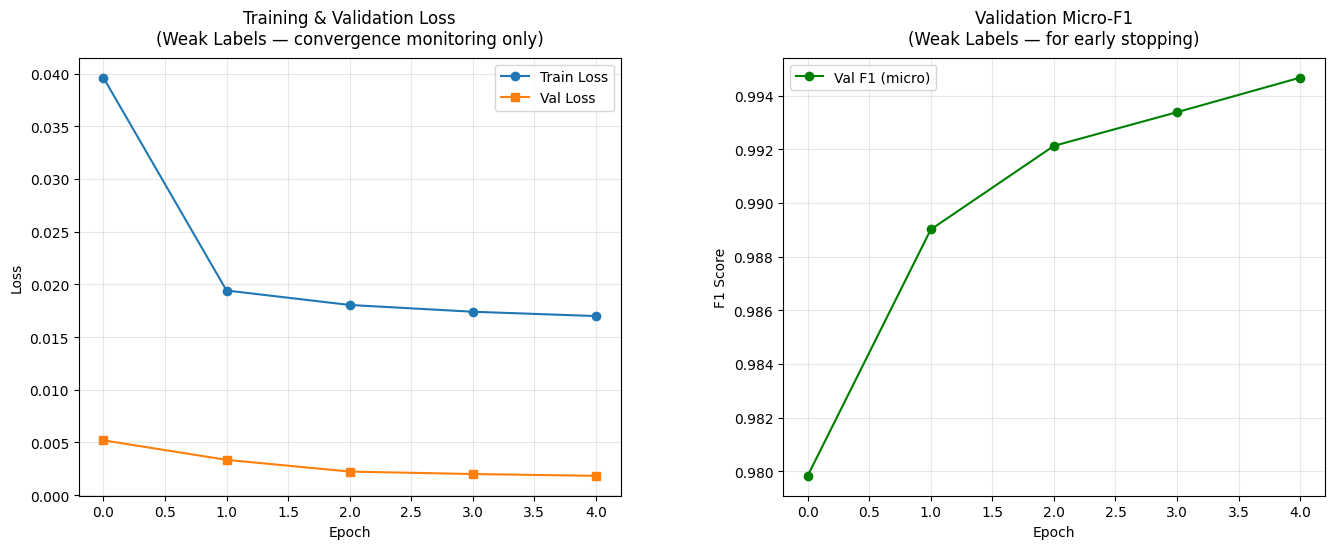

In [25]:
import matplotlib.pyplot as plt
# =============================================================================
# PLOT 1: Training curves — convergence monitoring (weak labels)
# These reflect performance on the noisy val split and are used for early
# stopping only. They are NOT the reported performance.
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(top=0.85, bottom=0.12, left=0.08, right=0.97, wspace=0.3)

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss\n(Weak Labels — convergence monitoring only)', pad=10)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history['val_f1_micro'], label='Val F1 (micro)', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation Micro-F1\n(Weak Labels — for early stopping)', pad=10)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.show()

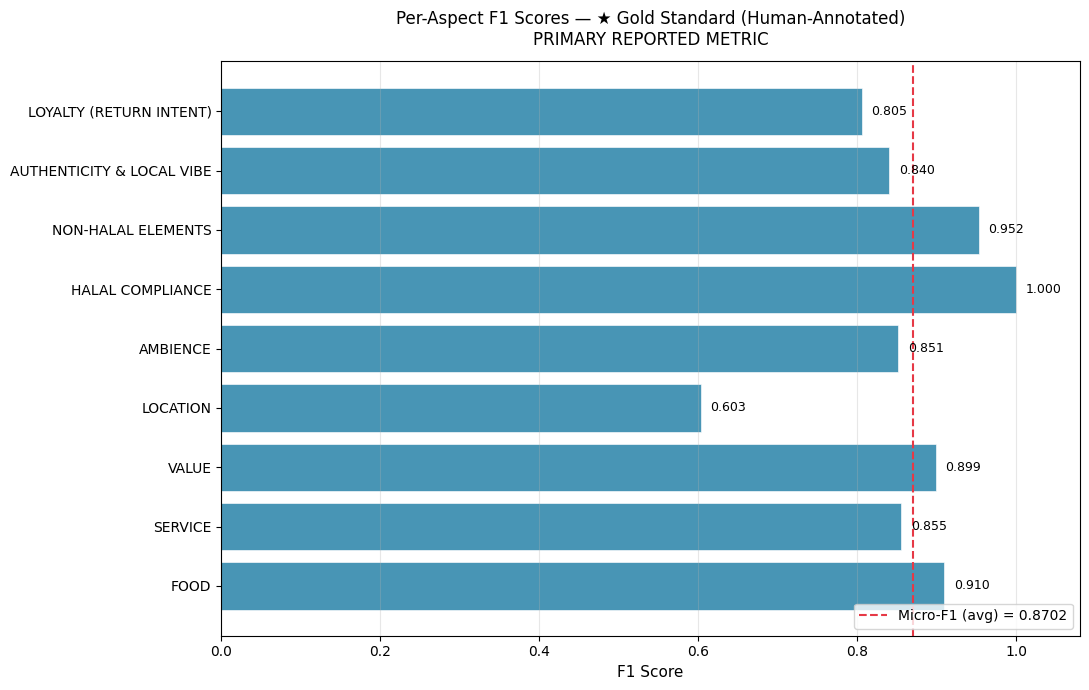


  FINAL MODEL PERFORMANCE  (★ Gold Standard)
  Metric                            Value
  ---------------------------- ----------
  f1_micro                         0.8702
  f1_macro                         0.8573
  precision_micro                  0.8160
  recall_micro                     0.9321
  hamming_loss                     0.0348

  ★ Reported metric: Gold Standard Micro-F1 = 0.8702


In [24]:
import matplotlib.pyplot as plt
# =============================================================================
# PLOT 2: Per-Aspect F1 — Gold Standard (PRIMARY REPORTED METRIC)
# =============================================================================
if gold_metrics is not None:
    gold_f1 = [gold_metrics.get(f"f1_{aspect}", 0.0) for aspect in CFG.aspect_labels]

    fig, ax = plt.subplots(figsize=(11, 7))
    bars = ax.barh(CFG.aspect_labels, gold_f1, color='#2E86AB', alpha=0.88, edgecolor='white', linewidth=0.5)

    # Annotate each bar with the F1 value
    for bar, val in zip(bars, gold_f1):
        ax.text(val + 0.012, bar.get_y() + bar.get_height() / 2,
                f'{val:.3f}', va='center', ha='left', fontsize=9)

    ax.set_xlabel('F1 Score', fontsize=11)
    ax.set_title(
        'Per-Aspect F1 Scores — ★ Gold Standard (Human-Annotated)\n'
        'PRIMARY REPORTED METRIC',
        fontsize=12, pad=12
    )
    ax.set_xlim(0, 1.08)
    ax.axvline(
        x=gold_metrics['f1_micro'], color='#E63946', linestyle='--', linewidth=1.5,
        label=f"Micro-F1 (avg) = {gold_metrics['f1_micro']:.4f}"
    )
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Final summary table — gold standard only
    print("\n" + "=" * 50)
    print("  FINAL MODEL PERFORMANCE  (★ Gold Standard)")
    print("=" * 50)
    print(f"  {'Metric':<28} {'Value':>10}")
    print(f"  {'-'*28} {'-'*10}")
    for metric in ['f1_micro', 'f1_macro', 'precision_micro', 'recall_micro', 'hamming_loss']:
        g = gold_metrics.get(metric, float('nan'))
        print(f"  {metric:<28} {g:>10.4f}")
    print(f"\n  ★ Reported metric: Gold Standard Micro-F1 = {gold_metrics['f1_micro']:.4f}")

else:
    # Fallback if gold standard failed to load
    print("  ⚠️  Gold standard unavailable. Falling back to weak-label test metrics.")
    print("  These are noisy — re-run Stage 7 once gold_standard.csv is accessible.\n")
    aspect_f1_scores = [test_metrics.get(f"f1_{aspect}", 0.0) for aspect in CFG.aspect_labels]
    plt.figure(figsize=(11, 7))
    plt.barh(CFG.aspect_labels, aspect_f1_scores, color='#A8DADC')
    plt.xlabel('F1 Score')
    plt.title('Per-Aspect F1 Scores\n(Weak-Label Test Split — gold standard unavailable)')
    plt.xlim(0, 1.0)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


# STAGE 9: Iterative Label Refinement — Re-label Full Dataset for Sentiment Classification

## Why Re-label?

The original `Aspect_Labels` in the dataset were produced by **dictionary + fuzzy matching** (weak labels).  
After training, XLM-RoBERTa **outperforms the dictionary** on the gold standard because it:

- Captures **implicit aspects** not listed in the dictionary (e.g., *"will come back"* → `LOYALTY`)
- Handles **Manglish code-switching** that the dictionary struggles with
- Generalises to **morphological variants** the fuzzy matcher may miss

Using the trained model's predictions as **refined labels** for the sentiment classifier pipeline gives a cleaner training signal.

## Methodology (Iterative Weak Supervision)

> Ratner et al. (2020). *"Snorkel: Rapid Training Data Creation with Weak Supervision"*. VLDB.  
> DOI: [10.14778/3401960.3401968](https://doi.org/10.14778/3401960.3401968)

**Safeguards applied:**
1. **Gold standard segments are excluded** — their labels were human-verified and must not be overwritten
2. **Confidence filter** (`min_confidence`) — only replace labels when the model is sufficiently confident; low-confidence predictions revert to original dictionary labels
3. **Both label versions are saved** — `Aspect_Labels_dict` (original) and `Aspect_Labels` (refined), so downstream experiments can compare

## Output
`aspect_categorization_refined.pkl` — drop-in replacement for `aspect_categorization_after_filtering.pkl` in the sentiment model

In [19]:
# ── Dictionary per-aspect F1 baseline (from 4a. AspectDictionaryEvaluationOnGoldStandard.ipynb) ──
# These are the scores the XLM-RoBERTa model must beat (per aspect) before its
# predictions replace the dictionary labels for that aspect.
DICT_BASELINE_F1 = {
    'FOOD':                        0.904,
    'SERVICE':                     0.856,
    'VALUE':                       0.895,
    'LOCATION':                    0.613,   # ← worst: P=0.475, critical over-prediction
    'AMBIENCE':                    0.850,
    'HALAL COMPLIANCE':            1.000,   # ← perfect: never replace
    'NON-HALAL ELEMENTS':          0.930,   # ← strong: hard to beat
    'AUTHENTICITY & LOCAL VIBE':   0.800,
    'LOYALTY (RETURN INTENT)':     0.805,
}


def refine_dataset_labels(
    cfg: AspectTrainingConfig,
    model,
    tokenizer,
    gold_metrics: dict,
    full_data_path: str = None,
    min_improvement: float = 0.03,
    min_confidence: float = 0.3,
    output_path: str = None,
) -> pd.DataFrame:
    """Selectively re-label the full dataset using XLM-RoBERTa predictions.

    SELECTIVE ITERATIVE LABEL REFINEMENT
    Ref: Ratner et al. (2020) "Snorkel: Rapid Training Data Creation with
         Weak Supervision", VLDB. DOI: 10.14778/3401960.3401968

    For each aspect independently, the model's label replaces the dictionary
    label ONLY if:
        XLM_F1(aspect) > Dict_F1(aspect) + min_improvement

    This is data-driven: if the model has not demonstrated a meaningful
    improvement on the gold standard for a given aspect, the (possibly more
    precise) dictionary label is retained for that aspect.

    Key safeguards:
        1. Per-aspect gating: replacement is aspect-specific, not all-or-nothing
        2. Gold standard segments: never re-labeled (human-verified)
        3. Confidence filter: low-confidence model predictions revert to dict
        4. Original labels preserved in 'Aspect_Labels_dict' for ablation

    Args:
        cfg:             AspectTrainingConfig
        model:           Trained MultiLabelAspectClassifier
        tokenizer:       XLM-RoBERTa tokenizer
        gold_metrics:    Dict from evaluate_on_gold_standard() — contains
                         per-aspect XLM F1 scores (keys: 'f1_ASPECT_NAME')
        full_data_path:  Path to original pkl (default: cfg.data_path)
        min_improvement: Model must exceed dict F1 by this margin to replace
        min_confidence:  Min sigmoid probability to treat as a valid prediction
        output_path:     Output pkl path

    Returns:
        DataFrame with refined Aspect_Labels and Aspect_Labels_dict preserved
    """
    print("\n" + "=" * 70)
    print("STAGE 9: SELECTIVE ITERATIVE LABEL REFINEMENT")
    print("=" * 70)
    print(f"  Rule: Replace aspect label if XLM_F1 > Dict_F1 + {min_improvement}")
    print(f"  Confidence filter: min_confidence = {min_confidence}")
    print(f"  Gold standard segments: excluded (labels preserved)\n")

    # ── Step 1: Decide which aspects to replace ───────────────────────────
    print("  ASPECT-LEVEL RE-LABELING DECISION:")
    print(f"  {'Aspect':<35} {'Dict F1':>8} {'XLM F1':>8} {'Δ':>7}  Decision")
    print(f"  {'-'*35} {'-'*8} {'-'*8} {'-'*7}  {'-'*12}")

    aspects_to_replace = []
    aspects_to_keep = []

    for aspect in cfg.aspect_labels:
        dict_f1 = DICT_BASELINE_F1.get(aspect, 0.0)
        xlm_f1_key = f"f1_{aspect}"
        xlm_f1 = gold_metrics.get(xlm_f1_key, 0.0) if gold_metrics else 0.0
        delta = xlm_f1 - dict_f1

        if delta > min_improvement:
            decision = "✓ REPLACE"
            aspects_to_replace.append(aspect)
        else:
            decision = "— keep dict"
            aspects_to_keep.append(aspect)

        print(f"  {aspect:<35} {dict_f1:>8.3f} {xlm_f1:>8.3f} {delta:>+7.3f}  {decision}")

    print(f"\n  Aspects using XLM labels:  {len(aspects_to_replace)} → {aspects_to_replace}")
    print(f"  Aspects keeping dict labels: {len(aspects_to_keep)} → {aspects_to_keep}")

    if not aspects_to_replace:
        print("\n  ⚠️  No aspects qualify for replacement. Dictionary is competitive.")
        print("  Consider lowering min_improvement or training more epochs.")
        return None

    # ── Step 2: Load full dataset ─────────────────────────────────────────
    data_path = full_data_path or cfg.data_path
    df = pd.read_pickle(data_path)
    print(f"\n  ✓ Loaded full dataset: {len(df):,} segments")

    # Preserve original weak labels for ablation comparison
    df['Aspect_Labels_dict'] = df['Aspect_Labels'].copy()

    # ── Step 3: Identify gold standard segments (never re-label) ─────────
    gold_segments = set()
    try:
        gold_df = pd.read_csv(cfg.gold_data_path)
        if 'Segment' in gold_df.columns:
            gold_segments = set(gold_df['Segment'].dropna().unique())
            print(f"  ✓ Protected {len(gold_segments):,} gold standard segments")
    except Exception as e:
        print(f"  ⚠️  Could not load gold standard for exclusion: {e}")

    mask_relabel = ~df['Segment'].isin(gold_segments) if (gold_segments and 'Segment' in df.columns) \
        else pd.Series(True, index=df.index)

    n_relabel = mask_relabel.sum()
    print(f"  Segments eligible for re-labeling: {n_relabel:,}\n")

    # ── Step 4: Batch inference on eligible segments ──────────────────────
    model.eval()
    segments_to_relabel = df[mask_relabel]['Segment'].tolist()
    batch_size = cfg.batch_size * 2
    all_probs = []

    print(f"  Running inference...")
    for start in tqdm(range(0, len(segments_to_relabel), batch_size), desc="  Inferring"):
        batch_texts = segments_to_relabel[start: start + batch_size]
        encoding = tokenizer(
            batch_texts, add_special_tokens=True, max_length=cfg.max_seq_length,
            padding="max_length", truncation=True, return_tensors="pt",
        )
        with torch.no_grad():
            logits = model(
                input_ids=encoding["input_ids"].to(DEVICE),
                attention_mask=encoding["attention_mask"].to(DEVICE),
            )
            all_probs.append(torch.sigmoid(logits).cpu().numpy())

    all_probs = np.vstack(all_probs)  # (N_relabel, 9)

    # ── Step 5: Apply per-aspect thresholds ───────────────────────────────
    thresholds_vec = np.array([
        cfg.per_aspect_thresholds.get(asp, cfg.prediction_threshold)
        if cfg.per_aspect_thresholds else cfg.prediction_threshold
        for asp in cfg.aspect_labels
    ])
    pred_binary = (all_probs > thresholds_vec).astype(int)

    # Confidence filter: max prob across all aspects
    max_prob = all_probs.max(axis=1)
    low_confidence = max_prob < min_confidence
    n_low_conf = low_confidence.sum()
    print(f"  Low-confidence predictions (reverting to dict): {n_low_conf:,} ({n_low_conf/n_relabel*100:.1f}%)")

    # ── Step 6: Selectively merge labels per aspect ───────────────────────
    # For aspects in aspects_to_replace: use model prediction
    # For aspects in aspects_to_keep:    keep dictionary label
    # We do this at the aspect level, not the segment level.

    replace_idx_set = {cfg.aspect_labels.index(a) for a in aspects_to_replace}
    relabel_idx = df[mask_relabel].index

    change_counts = {asp: 0 for asp in aspects_to_replace}
    n_low_conf_reverted = 0

    for i, idx in enumerate(relabel_idx):
        orig_aspects = set(df.loc[idx, 'Aspect_Labels_dict']) \
            if isinstance(df.loc[idx, 'Aspect_Labels_dict'], list) else set()

        if low_confidence[i]:
            # Low confidence: keep all original dict labels unchanged
            n_low_conf_reverted += 1
            continue

        refined_aspects = set(orig_aspects)  # start from dict labels

        for j in replace_idx_set:
            aspect = cfg.aspect_labels[j]
            model_says_present = bool(pred_binary[i, j])
            dict_says_present = aspect in orig_aspects

            # Replace this aspect's assignment with model's decision
            if model_says_present and not dict_says_present:
                refined_aspects.add(aspect)
                change_counts[aspect] += 1
            elif not model_says_present and dict_says_present:
                refined_aspects.discard(aspect)
                change_counts[aspect] += 1

        df.at[idx, 'Aspect_Labels'] = sorted(list(refined_aspects)) if refined_aspects else ['GENERAL']

    # ── Step 7: Change summary ────────────────────────────────────────────
    print(f"\n  LABEL CHANGES PER REPLACED ASPECT:")
    print(f"  {'Aspect':<35} {'Segments Changed':>16}")
    print(f"  {'-'*35} {'-'*16}")
    total_changes = 0
    for asp in aspects_to_replace:
        c = change_counts[asp]
        total_changes += c
        print(f"  {asp:<35} {c:>16,}")
    print(f"\n  Total segment-aspect assignments changed: {total_changes:,}")
    print(f"  Segments with ≥1 change: {sum(1 for i in relabel_idx if list(df.loc[i,'Aspect_Labels']) != list(df.loc[i,'Aspect_Labels_dict'])):,} / {n_relabel:,}")

    # ── Step 8: Save ──────────────────────────────────────────────────────
    if output_path is None:
        output_path = "/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_refined.pkl"

    df.to_pickle(output_path)
    print(f"\n  ✓ Saved refined dataset → {output_path}")
    print(f"  Columns: 'Aspect_Labels' (refined) + 'Aspect_Labels_dict' (original, for ablation)")
    print("\n" + "=" * 70)
    print("  NEXT: Use aspect_categorization_refined.pkl in sentiment model")
    print("=" * 70)

    return df


# ── RUN ─────────────────────────────────────────────────────────────────
# Requires gold_metrics from Stage 7 to determine which aspects to replace.
if gold_metrics is not None:
    refined_df = refine_dataset_labels(
        cfg=CFG,
        model=model,
        tokenizer=tokenizer,
        gold_metrics=gold_metrics,
        min_improvement=0.03,   # Model must be >3pp better per aspect to replace
        min_confidence=0.3,
        output_path="/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_refined.pkl",
    )
else:
    print("⚠️  Run Stage 7 (gold standard evaluation) first to get per-aspect XLM F1 scores.")



STAGE 9: SELECTIVE ITERATIVE LABEL REFINEMENT
  Rule: Replace aspect label if XLM_F1 > Dict_F1 + 0.03
  Confidence filter: min_confidence = 0.3
  Gold standard segments: excluded (labels preserved)

  ASPECT-LEVEL RE-LABELING DECISION:
  Aspect                               Dict F1   XLM F1       Δ  Decision
  ----------------------------------- -------- -------- -------  ------------
  FOOD                                   0.904    0.910  +0.006  — keep dict
  SERVICE                                0.856    0.855  -0.001  — keep dict
  VALUE                                  0.895    0.899  +0.004  — keep dict
  LOCATION                               0.613    0.603  -0.010  — keep dict
  AMBIENCE                               0.850    0.851  +0.001  — keep dict
  HALAL COMPLIANCE                       1.000    1.000  +0.000  — keep dict
  NON-HALAL ELEMENTS                     0.930    0.952  +0.022  — keep dict
  AUTHENTICITY & LOCAL VIBE              0.800    0.840  +0.040  ✓ REPLA

  Inferring:   0%|          | 0/1923 [00:00<?, ?it/s]

  Low-confidence predictions (reverting to dict): 0 (0.0%)

  LABEL CHANGES PER REPLACED ASPECT:
  Aspect                              Segments Changed
  ----------------------------------- ----------------
  AUTHENTICITY & LOCAL VIBE                         22

  Total segment-aspect assignments changed: 22
  Segments with ≥1 change: 15,751 / 123,042

  ✓ Saved refined dataset → /content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_refined.pkl
  Columns: 'Aspect_Labels' (refined) + 'Aspect_Labels_dict' (original, for ablation)

  NEXT: Use aspect_categorization_refined.pkl in sentiment model
